In [1]:
%pylab inline
from constant import * 

Populating the interactive namespace from numpy and matplotlib


In [2]:
Vgrid = np.load("Value.npy")

Probability of transition between employment and unemployment states is know: $P(0, 1 | S)$, $P(1, 0 | S)$, $P(1, 1 | S)$, $P(0, 0 | S)$   
   
   
The unconditional probability is:    
$$P(0,1) = \Sigma_{s = 1}^{s = 8}P(0, 1 | S = s)P(S=s)$$

In [3]:
S_distribution = jnp.ones(nS)/nS
for i in range(100):
    S_distribution = jnp.matmul(S_distribution, Ps)
S_distribution

DeviceArray([0.08723426, 0.12654275, 0.11381963, 0.17240335, 0.17240335,
             0.11381961, 0.12654276, 0.08723425], dtype=float32)

In [4]:
#P(0,1)
P01 = jnp.dot(Pe[:,0],S_distribution)
#P(1,0)
P10 = jnp.dot(Pe[:,1],S_distribution)
jnp.array([[1-P01, P01],[P10, 1-P10]])

DeviceArray([[0.23330271, 0.7666973 ],
             [0.06959809, 0.9304019 ]], dtype=float32)

In [5]:
E_distribution = jnp.ones(2)/2
for i in range(100):
    E_distribution = jnp.matmul(E_distribution, jnp.array([[1-P01, P01],[P10, 1-P10]]))
E_distribution

DeviceArray([0.08322192, 0.91677827], dtype=float32)

In [6]:
num = 10000
'''
    x = [w,n,m,s,e,o]
    x = [5,0,0,0,0,0]
'''
from jax import random

def simulation(key):
    initE = random.choice(a = nE, p=E_distribution, key = key)
    initS = random.choice(a = nS, p=S_distribution, key = key)
    x = [5, 0, 0, initS, initE, 0]
    path = []
    move = []
    for t in range(T_min, T_max-1):
        _, key = random.split(key)
        _,a = V(t,Vgrid[:,:,:,:,:,:,t+1],x)
        xp = transition(t,a.reshape((1,-1)),x)
        p = xp[:,-1]
        x_next = xp[:,:-1]
        path.append(x)
        move.append(a)
        x = x_next[random.choice(a = nS*nE, p=p, key = key)]
    return jnp.array(path), jnp.array(move)

In [7]:
%%time
# simulation part 
keys = vmap(random.PRNGKey)(jnp.arange(num))
Paths, Moves = vmap(simulation)(keys)

CPU times: user 4h 28min 58s, sys: 23min 57s, total: 4h 52min 55s
Wall time: 13min 19s


In [8]:
# x = [w,n,m,s,e,o]
# x = [0,1,2,3,4,5]
ws = Paths[:,:,0].T
ns = Paths[:,:,1].T
ms = Paths[:,:,2].T
ss = Paths[:,:,3].T
es = Paths[:,:,4].T
os = Paths[:,:,5].T
cs = Moves[:,:,0].T
bs = Moves[:,:,1].T
ks = Moves[:,:,2].T
hs = Moves[:,:,3].T
actions = Moves[:,:,4].T

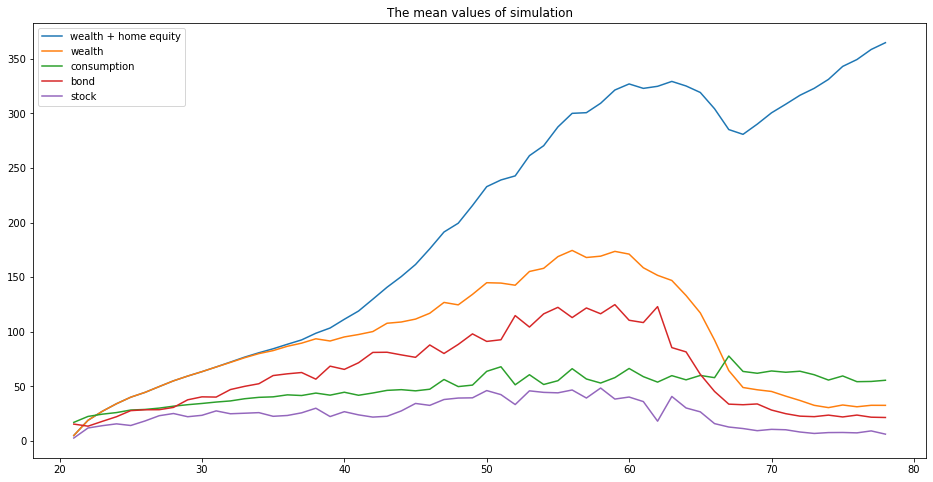

In [9]:
plt.figure(figsize = [16,8])
plt.title("The mean values of simulation")
plt.plot(range(21, T_max-1 + 20),jnp.mean(ws + H*pt*os - ms,axis = 1)[:-1], label = "wealth + home equity")
plt.plot(range(21, T_max-1 + 20),jnp.mean(ws,axis = 1)[:-1], label = "wealth")
plt.plot(range(21, T_max-1 + 20),jnp.mean(cs,axis = 1)[:-1], label = "consumption")
plt.plot(range(21, T_max-1 + 20),jnp.mean(bs,axis = 1)[:-1], label = "bond")
plt.plot(range(21, T_max-1 + 20),jnp.mean(ks,axis = 1)[:-1], label = "stock")
# plt.plot((hs*pr).mean(axis = 1)[:-1], label = "housing")
plt.legend()

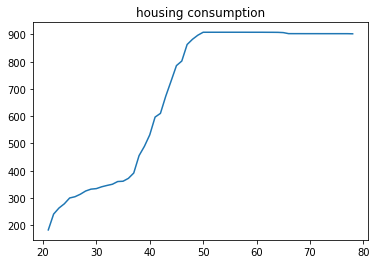

In [10]:
plt.title("housing consumption")
plt.plot(range(21, T_max-1 + 20),(hs).mean(axis = 1)[:-1], label = "housing")

In [11]:
(os).mean(axis = 1)[:-1]

DeviceArray([0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
             0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 1.000e-04,
             8.000e-04, 5.000e-03, 8.900e-03, 1.260e-02, 2.710e-02,
             2.830e-02, 4.560e-02, 7.890e-02, 1.916e-01, 2.519e-01,
             3.261e-01, 4.423e-01, 4.663e-01, 5.792e-01, 6.782e-01,
             7.790e-01, 8.087e-01, 9.167e-01, 9.508e-01, 9.774e-01,
             9.968e-01, 9.968e-01, 9.968e-01, 9.968e-01, 9.968e-01,
             9.968e-01, 9.968e-01, 9.968e-01, 9.968e-01, 9.967e-01,
             9.967e-01, 9.967e-01, 9.965e-01, 9.964e-01, 9.961e-01,
             9.945e-01, 9.877e-01, 9.876e-01, 9.876e-01, 9.875e-01,
             9.875e-01, 9.875e-01, 9.874e-01, 9.874e-01, 9.874e-01,
             9.874e-01, 9.874e-01, 9.874e-01], dtype=float32)

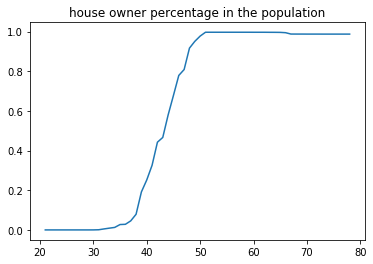

In [12]:
plt.title("house owner percentage in the population")
plt.plot(range(21, T_max-1 + 20),(os).mean(axis = 1)[:-1], label = "owning")

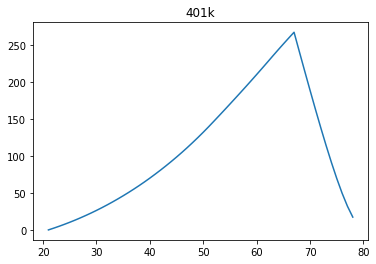

In [13]:
plt.title("401k")
plt.plot(range(21, T_max-1 + 20),(ns).mean(axis = 1)[:-1], label = "housing")

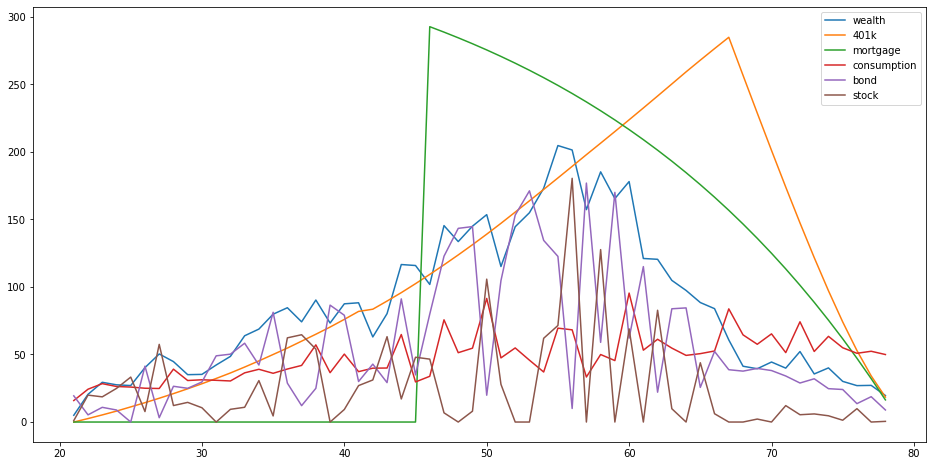

In [14]:
# agent number, x = [w,n,m,s,e,o]
agentNum = 11
plt.figure(figsize = [16,8])
plt.plot(range(21, T_max-1 + 20),ws[:,agentNum][:-1], label = "wealth")
plt.plot(range(21, T_max-1 + 20),ns[:,agentNum][:-1], label = "401k")
plt.plot(range(21, T_max-1 + 20),ms[:,agentNum][:-1], label = "mortgage")
plt.plot(range(21, T_max-1 + 20),cs[:,agentNum][:-1], label = "consumption")
plt.plot(range(21, T_max-1 + 20),bs[:,agentNum][:-1], label = "bond")
plt.plot(range(21, T_max-1 + 20),ks[:,agentNum][:-1], label = "stock")
plt.legend()

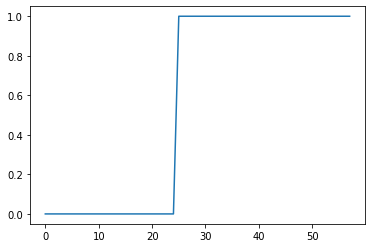

In [15]:
plt.plot(os[:,agentNum][:-1])

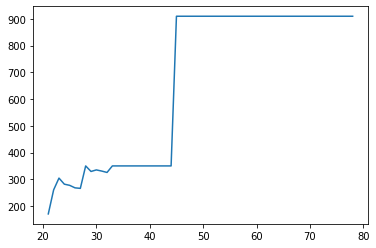

In [16]:
plt.plot(range(21, T_max-1 + 20),hs[:,agentNum][:-1], label = "stock")